## Empirical investigation of the anatomical drivers during aging

The current notebook explores the structural connectivity matrices of the 1000BRAINS dataset (Caspers et al., 2014). Its sole purpose is to show the main structural drivers behind senescence and, therefore, why it makes to induce virtual aging by decreasing the intehemispheric connectivity.   

## Data alert 

The current notebook assumes that the dataset is located in the folder `$MYPATH/aging_virtual_brain/data/external`. First, verify that the dataset is present before running any codeblock.

The access to this dataset is regulated by the EBRAINS platform. Therefore, any user must register to EBRAINS and request the access to dataset on the same platform by accepting the Data Users Agreement, which is a valid MTA.

Once registered, the access to this dataset is protected by the Human Data Gateway, and has to be explicitly requested. Please click the following link: [request access](https://data-proxy.ebrains.eu/datasets/83407c06-b494-4307-861e-d06a5aecdf8a). When granted, the right to access lasts 24 hours.

Alternatively, the access request link can be found in the Knowledge Graph page of the dataset under the *Get data* menu item: https://doi.org/10.25493/6640-3XH.

<div>
<img src="image_1000BD_EBRAINS.png" width="1000"/>
</div>

Have you download the data according to the suggested procedure? If yes, go ahead. If no, 
### ***Re-read carefully the data alert block***

## Import packages

Import the most useful packages for this notebook

In [16]:
import numpy as np
from numpy import linalg
import matplotlib.pylab as plt
from src import data 
from scipy import special
import math
import os
from scipy import stats
import pandas as pd
import seaborn as sns
import re
import time
from scipy.sparse import csgraph
from scipy.sparse import csr_matrix
import pandas as pd
from pingouin import ancova
from pingouin import partial_corr

The next codeblock uploads the 1000BRAINS dataset, the list of regions and the list of metadata of each subject. Please pay attention that the code uploads both the list of subjs of the folder and the list of all 1000BRAINS subjects of the study (available in csv). Do refer to the variable subjs and the sorted output based on the available data in the folder.

If you have downloaded the data correctly (see ***Data Alert*** block), the codeblock should not give any error message

In [17]:
separator     = ''
jul           = data.Julich() 
subjs         = jul.list_subjects()
parce_list    = jul.parcellation_100()
_,_,_,_,age_sort,gender_sort,edu_sort,subjs = jul.metadata()

## Investigation of the SC drivers for aging

The following loop collects all the SC matrices and compute the average SC connectivity as well as the average interhemispheric and intrahemispheric SC connectivity by masking the antidiagonal and diagonal block of each SC matrix (see Figure 2.D in the paper or in the following codeblocks). We also compute the algebraic connectivity, which is the second smallest eigenvalue of the Laplacian of the SC matrix, to test whether the virtual aging by edge-masking is reasonable.

In [18]:
subj_list_emp  = []
age_list_emp   = []
sex_list_emp   = []
edu_list_emp   = []


_, weights     = jul.load_subject_sc_100(subjs[0])
NHALF          = int(weights.shape[0]/2)

SC_SC_MATRIX_EMP           = np.empty([len(subjs),len(parce_list)]) 
SC_SC_inter_EMP            = np.empty([len(subjs),NHALF*NHALF*2])
SC_SC_intra_EMP            = np.empty([len(subjs),NHALF*NHALF*2])

PART_SC_MATRIX_EMP         = np.empty([len(subjs),1]) #

SC_SC_MATRIX_EMP[:]        = np.nan
SC_SC_inter_EMP[:]         = np.nan
SC_SC_intra_EMP[:]         = np.nan


PART_SC_MATRIX_EMP[:]      = np.nan


for subj_idx in range(len(subjs)):
    
    mysubj         = subjs[subj_idx]
    myage          = age_sort[subj_idx]
    
    if gender_sort[subj_idx] == 'Female':
        mysex          = 1
    else:
        mysex          = 0
        
    myedu          = edu_sort[subj_idx]
    
    try:
        
        _, weights    = jul.load_subject_sc_100(mysubj)
        NHALF         = int(weights.shape[0]/2)

        t0 = time.time()

        MAT_WEIGHT        = weights
        magic_number      = 124538.470647693 ## Maximum Edge of the entire cohort

        weights_norm      = MAT_WEIGHT/magic_number

        mask_inter                              = np.zeros(MAT_WEIGHT.shape)
        mask_inter[0:NHALF,NHALF:NHALF*2]       = 1
        mask_inter[NHALF:NHALF*2,0:NHALF]       = 1

        mask_intra                              = np.zeros(MAT_WEIGHT.shape)
        mask_intra[0:NHALF,0:NHALF]             = 1
        mask_intra[NHALF:NHALF*2,NHALF:NHALF*2] = 1

        weights_inter                           = (MAT_WEIGHT*mask_inter).ravel()
        weights_intra                           = (MAT_WEIGHT*mask_intra).ravel()

        L_csg                                   = csgraph.laplacian(weights_norm, normed=True)
        wSC, vSC                                = linalg.eig(L_csg)

        PART_SC_MATRIX_entry                    = np.sort(wSC)[1]

        SC_SC_inter_entry                       = weights_inter[mask_inter.ravel()>0]
        SC_SC_intra_entry                       = weights_intra[mask_intra.ravel()>0]
        SC_SC_MATRIX_entry                      = np.sum(MAT_WEIGHT,axis=0)

        weights_intra              = (MAT_WEIGHT*mask_intra).ravel()
        fc_intra                   = (rsFC*mask_intra).ravel()

        weights_inter              = (MAT_WEIGHT*mask_inter).ravel()
        fc_inter                   = (rsFC*mask_inter).ravel()


        PART_SC_MATRIX_EMP[subj_idx]   = PART_SC_MATRIX_entry

        SC_SC_MATRIX_EMP[subj_idx,:]   = SC_SC_MATRIX_entry
        SC_SC_inter_EMP[subj_idx,:]    = SC_SC_inter_entry
        SC_SC_intra_EMP[subj_idx,:]    = SC_SC_intra_entry


    except:
        print('NO S100 data')
        pass
    
    subj_list_emp                  +=[mysubj]
    age_list_emp                   +=[myage]
    sex_list_emp                   +=[mysex]
    edu_list_emp                   +=[myedu]
    

NO S100 data


## Results of SC investigation: Average interhemispheric, intrahemispheric and whole-brain connectivity

The investigation of the empirical SC connectomes in 1000BRAINS dataset shows a common hallmark of ageing related to the restructuring of white matter connections. By computing the average SC connectivity, the average intrahemispheric and interhemispheric connectivity, we observed that:
1. The average SC link is decreasing, as shown by various studies on white matter restructuring [(Zhao et al. 2015)](http://doi.wiley.com/10.1002/hbm.22877)
2. The average intrahemispheric link is not decreasing across ageing
3. On the contrary, the interhemispheric connections show a sharp decrease with age, as shown by [(Puxeddu et al. 2020)](https://doi.org/10.1016/j.neuroimage.2020.116974)

The following figure shows the age-trend of the intrahemispheric connectivity corrected for sex and education

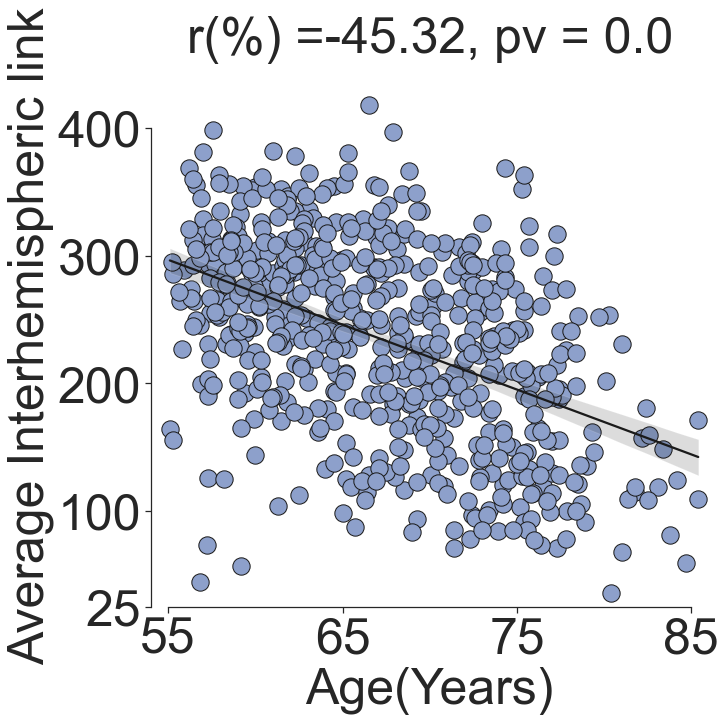

In [62]:
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("ticks")

path_root   = os.path.dirname(os.getcwd()) 
palette  = sns.color_palette("Set2", 12)
sns.set_style({"xtick.major.size":30, "ytick.major.size":30})

font_size = 50

cc_sc    = np.mean(SC_SC_inter_EMP,axis=1)
age_cc   = np.array(age_list_emp)

mygender_cs  = np.array(sex_list_emp)
myedu_cs     = np.array(edu_list_emp)

age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]


gender_rep     = mygender_cs
edu_rep        = myedu_cs
myfeat_aging   = cc_sc

df_SC          = pd.DataFrame({'gcoup':myfeat_aging,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})


f,ax = plt.subplots(figsize=(10,10))

separator = ''
str_yaxis = separator.join(['Average Interhemispheric link'])
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 300,"edgecolor":'k','alpha':1},line_kws={"color":'k'},color=palette[10])
ax.set_title(f'r(%) ={r_corr_sex.round(4)*100}, pv = {p_corr_sex.round(9)}',fontsize=font_size);
# ax.set_title(r'$\rho(\%) =-45.3$, $p \leq 0.001$',fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
# plt.xlim([54.5,86])

plt.xlim([54,86])
plt.ylim([25,450])

ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([25,100,200,300,400])


sns.despine(trim=True);

The following figure shows the age-trend of the intrahemispheric connectivity corrected for sex and education

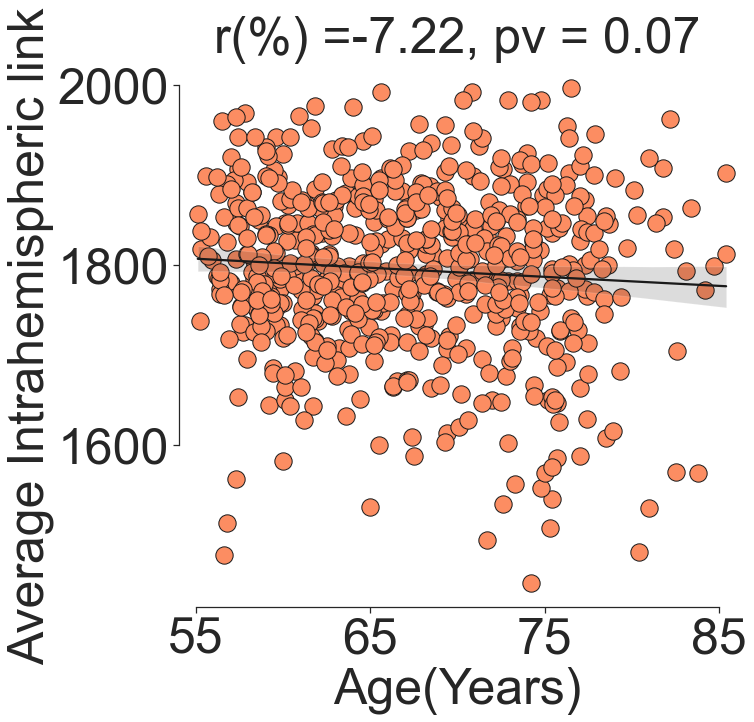

In [63]:
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("ticks")

path_root   = os.path.dirname(os.getcwd()) 
palette  = sns.color_palette("Set2", 12)
sns.set_style({"xtick.major.size":30, "ytick.major.size":30})

font_size    = 50

cc_sc        = np.mean(SC_SC_intra_EMP,axis=1)
age_cc       = np.array(age_list_emp)

mygender_cs  = np.array(sex_list_emp)
myedu_cs     = np.array(edu_list_emp)

age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]


gender_rep     = mygender_cs
edu_rep        = myedu_cs
myfeat_aging   = cc_sc

df_SC          = pd.DataFrame({'gcoup':myfeat_aging,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex     = pg["r"][0]
p_corr_sex     = pg["p-val"][0]

data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

f,ax = plt.subplots(figsize=(10,10))

separator = ''
str_yaxis = separator.join(['Average Intrahemispheric link'])
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 300,"edgecolor":'k','alpha':1},line_kws={"color":'k'},color=palette[9])
ax.set_title(f'r(%) ={r_corr_sex.round(4)*100}, pv = {p_corr_sex.round(2)}',fontsize=font_size);
# ax.set_title(r'$\rho(\%) =-45.3$, $p \leq 0.001$',fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

plt.xlim([54,86])
ax.set_xticks([55, 65, 75 ,85])
sns.despine(trim=True);


The following figure shows the age-trend of the whole-brain connectivity corrected for sex and education

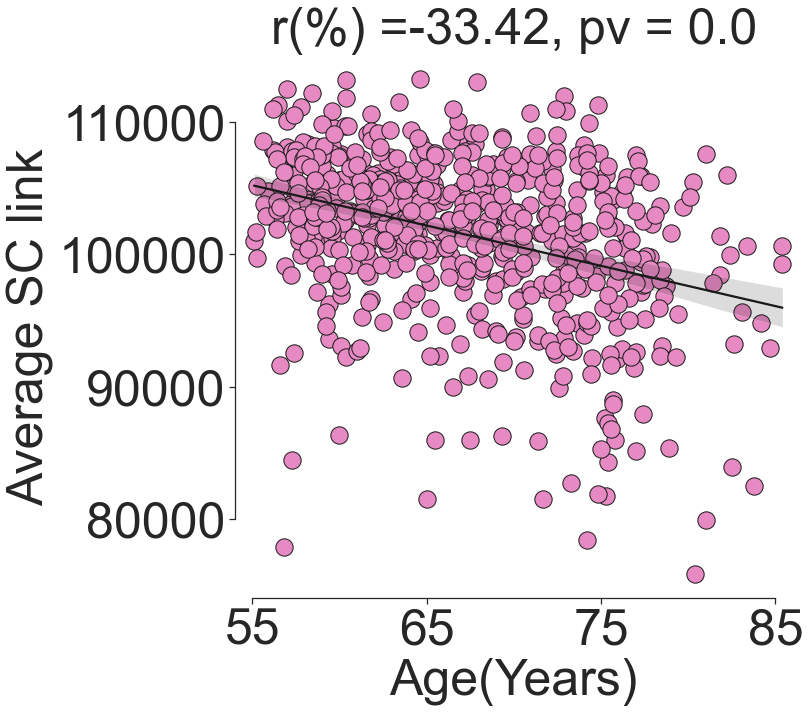

In [64]:
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("ticks")

path_root    = os.path.dirname(os.getcwd()) 
palette      = sns.color_palette("Set2", 12)
sns.set_style({"xtick.major.size":30, "ytick.major.size":30})

font_size      = 50

cc_sc          = np.mean(SC_SC_MATRIX_EMP,axis=1)
age_cc         = np.array(age_list_emp)

mygender_cs    = np.array(sex_list_emp)
myedu_cs       = np.array(edu_list_emp)

age_cc         = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs    = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs       = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc          = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]


gender_rep     = mygender_cs
edu_rep        = myedu_cs
myfeat_aging   = cc_sc

df_SC          = pd.DataFrame({'gcoup':myfeat_aging,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex     = pg["r"][0]
p_corr_sex     = pg["p-val"][0]


data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

f,ax = plt.subplots(figsize=(10,10))
separator = ''
str_yaxis = separator.join(['Average SC link'])
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 300,"edgecolor":'k','alpha':1},line_kws={"color":'k'},color=palette[11])
ax.set_title(f'r(%) ={r_corr_sex.round(4)*100}, pv = {p_corr_sex.round(9)}',fontsize=font_size);
# ax.set_title(r'$\rho(\%) =-45.3$, $p \leq 0.001$',fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

plt.xlim([54,86])

ax.set_xticks([55, 65, 75 ,85])
sns.despine(trim=True);


## Virtual aging: Masking procedure

We referred to this artificial decrease of the interhemispheric connections as virtual ageing or virtually ageing masking.

Specifically, we homogeneously decreased the interhemispheric connections from 0% up to 100%. Based on the empirical connectome, we can easily define a virtually aged connectivity as follows:

$$SC_{aged} = SC_{0} - \alpha * SC_{0} * M_{inter},$$

where $SC_{0}$ is the original connectivity, $*$ is the entry-by-entry product and $M_{inter}$ is interhemispheric matrix to select defined as follows:

$$ M_{inter} = \begin{bmatrix}
\mathbf{0} & \mathbf{1} \\
\mathbf{1} & \mathbf{0} 
\end{bmatrix}$$

and it looks like the plot below.

Text(0.5, 1.0, 'Interhemispheric Mask')

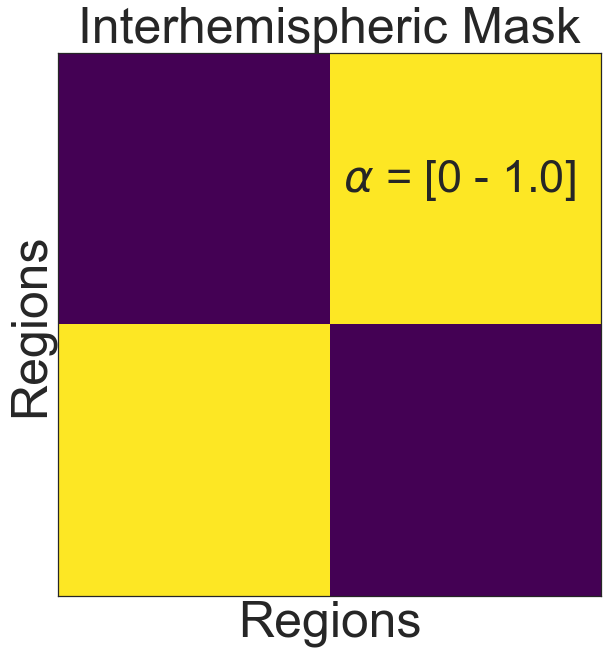

In [65]:
path_root  = os.path.dirname(os.getcwd())
font_size = 40

f,ax = plt.subplots(figsize=(10,10))

ax.imshow(mask_inter,cmap="viridis")
ax.set_ylabel("Regions",fontsize=font_size+10)
ax.set_xlabel("Regions",fontsize=font_size+10)

ax.set_yticks([]);
ax.set_xticks([]);

ax.grid(False)

ax.text(52, 25,r'$\alpha$ = [0 - 1.0]', fontsize=font_size+5)

separator = ''
str_title = separator.join(["Interhemispheric Mask"])
plt.title(str_title,fontsize=font_size+10)

The parameter $\alpha$ can be swept in range [0 - 1] to apply the homogenous decrease from 0% to 100%. To get an idea of this decrease, we can compare an original connectome with a virtually aged matrix with a 80% decrease. The application of this mask justifies the term masking or masked connectomes.

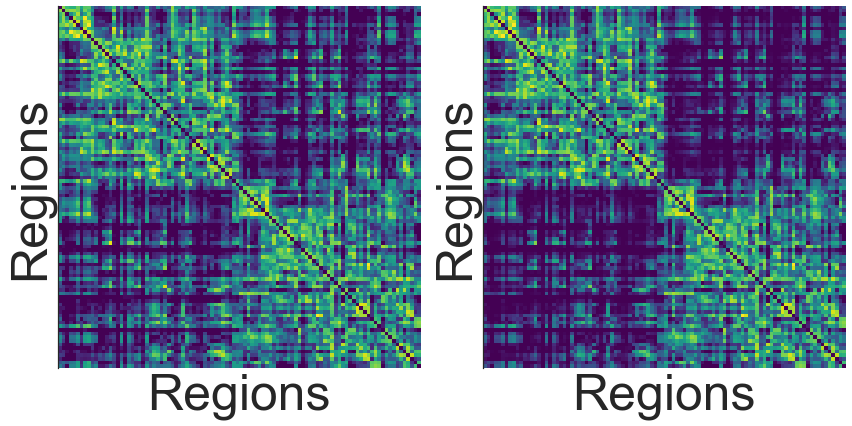

In [66]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
path_root  = os.path.dirname(os.getcwd())
font_size = 40

f,ax = plt.subplots(ncols=2,figsize=(12,12))

ax[0].imshow(np.log10(weights+1),cmap="viridis")
ax[0].set_ylabel("Regions",fontsize=font_size+10)
ax[0].set_xlabel("Regions",fontsize=font_size+10)

ax[0].set_yticks([]);
ax[0].set_xticks([]);

ax[0].grid(False)

ax[1].imshow(np.log10((weights-0.8*weights*mask_inter)+1),cmap="viridis")

ax[1].set_ylabel("Regions",fontsize=font_size+10)
ax[1].set_xlabel("Regions",fontsize=font_size+10)

ax[1].set_yticks([]);
ax[1].set_xticks([]);

ax[1].grid(False)

f.tight_layout()

sns.despine(bottom=True)
